# COGS 108 - Final Project 

# Overview

This project was conducted to see if there would be an correlation between the yelp review score and the health violations an establishment incurs. It was found that were was no correlation or significant differnce between the Yelp score and the violations as well as between the yelp score and the health inspection score. However, limitations in approach and data skew the results, so it is hard to say concretely there is not a correlation. 

# Name & PID

- Name: Kevin Hau
- PID: A12649934

# Research Question


Is there a relationship between the Yelp review score a restaurant receives and the health violations it may incur?

## Background and Prior Work

Within the realm of health inspections, the first thing that came into mind was Yelp. Health inspections help the public by making sure the restaurants within our local area are using safe food practices. Inspectors check for things such as food safety temperatures, poor personal hygiene, or sanitation etc. Based on the amount of violations and severity, the restaurant is given a grade ranging from A to C. The inspectors come back after a two week to two month period for another inspeciton. There are two articles that I found that have conducted research on similar topics. The second article referenced below uses Yelp reviews to help predict whether or not a restaurant was likely to have health code violations. They did so by building a predictive model based on key words within the reviews. Furthermore, they found that their model worked better when they used the reviews that were ranked highest. My question is very similar to what the researchers conducted. In the first referenced article, the article summarizes some research done within the New York restaurant health inspection area. They found that around 30 percent of all restaurants deteriorated their hygiene after 90 days of certification. However, they also found that online reviews were effective in identifying violations after certification. Overall, there seems to be strong evidence of a correlation between reviews and health inspection violations. 

References (include links):

1)https://www.consumeraffairs.com/news/restaurant-hygiene-are-influenced-by-health-inspections-and-customer-reviews-011420.html
2)https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4811425/

# Hypothesis


I believe that there will be a strong correlation between reviews a restaurant receieves and the potential health violations it may incur. This is based on the background that I researched on as well as personal experience.

# Dataset(s)

- Dataset Name: Inspections
- Link to the dataset: https://canvas.ucsd.edu/courses/12630/assignments/110486
- Number of observations: 18,467

Dataset contains the Inspections for any food serving businesses. It contains dates, health scores, violations count,location information etc. 

- Dataset Name: Yelp
- Link to the dataset: https://canvas.ucsd.edu/courses/12630/assignments/110486
- Number of observations: 3689

Dataset contains the Yelp scores and review counts for any food serving businesses. It contains dates, Yelp scores, review counts, location information etc. 

- Dataset Name: Restaurants
- Link to the dataset: https://canvas.ucsd.edu/courses/12630/assignments/110486
- Number of observations: 3325

Dataset contains restaurants within the state of North Carolina. It contains basic location data, hsisid, and facility type etc. 

# Setup

In [1]:
# Imports
# 
# Note: these are all the imports you need for this assignment!
# Do not import any other functions / packages

# Display plots directly in the notebook instead of in a new window
%matplotlib inline

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure libraries
# The seaborn library makes plots look nicer
sns.set()
sns.set_context('talk')

# Don't display too many rows/cols of DataFrames
pd.options.display.max_rows = 30
pd.options.display.max_columns = 11

# Round decimals when displaying DataFrames
pd.set_option('precision', 2)

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest
# Note: the statsmodels import may print out a 'FutureWarning'. Thats fine.

#setting dataframes from CSV files
df_yelp = pd.read_csv('yelp.csv')
df_resta = pd.read_csv('restaurants.csv')
df_inspect = pd.read_csv('inspections.csv')


# Data Cleaning

First, we will go through each dataframe and take out all the columns that are not needed. Then we will clear out any rows that do not have all the pertinent information. Then we will adjust each dataframe to be standard specifications needed such as all lower case etc. 

In [2]:
#Removing unnecessary columns
df_yelp = df_yelp[['id','name','rating','review_count', 'address1']]
df_resta = df_resta[['hsisid','name','address1']]
df_inspect = df_inspect[['hsisid','name','address1','score','num_critical', 'num_non_critical']]

#drop NA rows
df_yelp = df_yelp.dropna(subset = ['id','name','rating','review_count', 'address1'])
df_resta = df_resta.dropna(subset = ['hsisid','name','address1'])
df_inspect = df_inspect.dropna(subset = ['hsisid','name','address1','score','num_critical', 'num_non_critical'])

#make address column lower case
df_yelp['address1'] = df_yelp['address1'].str.lower()
df_resta['address1']= df_resta['address1'].str.lower()
df_inspect['address1'] = df_inspect['address1'].str.lower()

In [3]:
#cleaning function

def standardize_address(str_in):
    
    #make input all string
    str_in = str(str_in)
    
    # Make the input all lowercase and strip whitespace
    str_in = str_in.lower().strip()
    
    str_in = str_in.replace('avenue', 'ave')
    str_in = str_in.replace('ave.', 'ave')
    
    str_in = str_in.replace('road', 'rd')
    str_in = str_in.replace('rd.', 'rd')
    
    str_in = str_in.replace('steet', 'st')
    str_in = str_in.replace('st.', 'st')
    
    str_in = str_in.replace('lane', 'ln')
    str_in = str_in.replace('ln.', 'ln')
    
    str_in = str_in.replace('drive', 'dr')
    str_in = str_in.replace('dr.', 'dr')
    
    str_in = str_in.replace('boulevard', 'blvd')
    str_in = str_in.replace('blvd.', 'blvd')
    
    str_in = str_in.replace('highway', 'hwy')
    str_in = str_in.replace('hwy.', 'hwy')
    
    str_in = str_in.replace('parkway', 'pky')
    str_in = str_in.replace('pky.', 'pky')
    
    str_in = str_in.replace('circle', 'cir')
    
    str_in = str_in.replace('trail', 'trl')
    
    return str_in

In [4]:
#standardize all addresses
df_yelp['address1'] = df_yelp['address1'].apply(standardize_address)
df_resta['address1']= df_resta['address1'].apply(standardize_address)
df_inspect['address1'] = df_inspect['address1'].apply(standardize_address)

#drop rows with low review counts
df_yelp = df_yelp[df_yelp['review_count'] > 25] 

#average out columns in inspecitons num critical, num non critical, and score to unique hsisid
df_score = df_inspect.groupby('hsisid')['score'].mean().reset_index()
df_num_crit = df_inspect.groupby('hsisid')['num_critical'].mean().reset_index()
df_num_non_crit = df_inspect.groupby('hsisid')['num_non_critical'].mean().reset_index()

In [5]:
# Merge all Dataframes into 1
df1 = df_resta.merge(df_yelp, on ='address1', how='inner')
df2 = df1.merge(df_score, on = 'hsisid', how='inner')
df3 = df2.merge(df_num_crit, on = 'hsisid', how='inner')
df = df3.merge(df_num_non_crit, on = 'hsisid', how='inner')

#type cast score, num_crit, num_non_crit to float

df['score'] = df['score'].astype(np.float)
df['num_critical'] = df['num_critical'].astype(np.float)
df['num_non_critical'] = df['num_non_critical'].astype(np.float)
df

,hsisid,name_x,address1,id,name_y,rating,review_count,score,num_critical,num_non_critical
0,4092015333,THE REMEDY DINER,137 e hargett st,the-remedy-diner-raleigh,the remedy diner,4.0,347,94.00,3.75,6.12
1,4092016679,BITTERSWEET,16 e martin st,bittersweet-raleigh,bittersweet,4.0,150,99.40,1.80,1.00
2,4092014336,Bonefish Grill,4421 six forks rd,woof-gang-bakery-and-grooming-raleigh-raleigh,woof gang bakery & grooming raleigh,4.0,38,93.60,4.00,9.00
3,4092014336,Bonefish Grill,4421 six forks rd,panera-bread-raleigh-2,panera bread,3.5,45,93.60,4.00,9.00
4,4092014336,Bonefish Grill,4421 six forks rd,midtown-grille-raleigh,midtown grille,3.5,101,93.60,4.00,9.00
...,...,...,...,...,...,...,...,...,...,...
1137,4092016801,FREDDY'S FROZEN CUSTARD &amp; STEAKBURGERS #3202,1705 high house rd,freddys-frozen-custard-and-steakburgers-cary,freddy's frozen custard & steakburgers,3.5,51,93.50,3.25,6.25
1138,4092014534,Raleigh Times Bar,14 e hargett st,raleigh-times-bar-raleigh,raleigh times bar,4.0,481,93.57,5.86,8.43
1139,4092016359,DEAN'S SEAFOOD GRILL,1080 darrington dr,deans-seafood-grill-and-bar-cary,dean's seafood grill and bar,3.5,183,98.00,3.33,2.83
1140,4092016368,Golden Palace,4420 capital blvd,golden-palace-raleigh,golden palace,3.5,48,90.00,4.57,13.00


# Data Analysis & Results

We will be testing the distributions of our Yelp rating versus our health score. However, the main question was pertaining to how health violations related to yelp score. So if we can find a correlation between the number of critical and non critical violations with the score, we can use the score and yelp rating to see if our distrubition is normal. 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


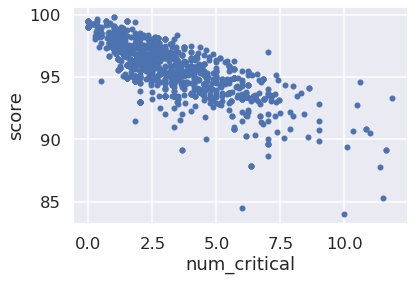

In [6]:
scatter = df.plot.scatter(x='num_critical', y='score')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


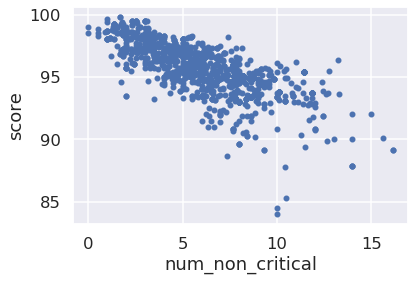

In [7]:
scatter = df.plot.scatter(x='num_non_critical', y='score')

As we can see, there is a negative correlation shown betweeen score and the violations incurred. The more violations a business incurred, the lower the score they got whether it be critical or non critical violations. 

Futhermore, there are definitely some outliers within the data set as shown. 

In [8]:
r_crit = df[df['rating'] > 3]['num_critical'].values
r_ncrit = df[df['rating'] < 3]['num_critical'].values

avg_r_crit = r_crit.mean()
avg_r_ncrit = r_ncrit.mean()

print('Average critical violations is \t {:2.3f}'.format(avg_r_crit))
print('Average critical violations is \t {:2.3f}'.format(avg_r_ncrit))


Average critical violations is 	 3.268
Average critical violations is 	 3.234


In [9]:
t_val = ttest_ind(r_crit, r_ncrit)[0]
p_val = ttest_ind(r_crit, r_ncrit)[1]

if p_val < 0.01:
    print('Data Science accomplished, there is a significant difference!')
else:
    print('There is NOT a significant difference!')

There is NOT a significant difference!


As shown by our ttest, there is no significant difference between the amount of critical violations and the yelp rating.

Next, we will focus on showing the graphs between the yelp rating and the number of critical and non critical violations.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


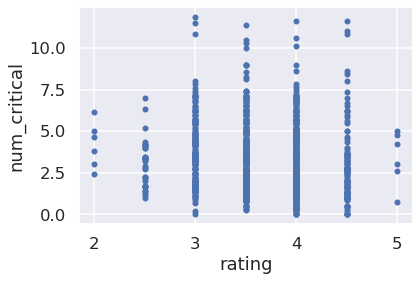

In [10]:
scatter = df.plot.scatter(x='rating', y='num_critical')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


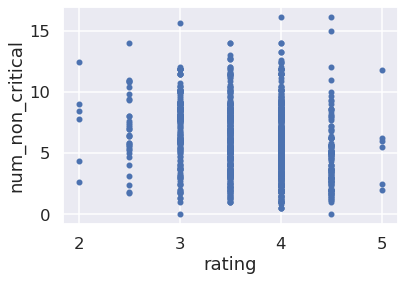

In [11]:
scatter = df.plot.scatter(x='rating', y='num_non_critical')

As we can see, it is hard to discern any significance within the graph. There may be some slight correlation but far from concrete.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


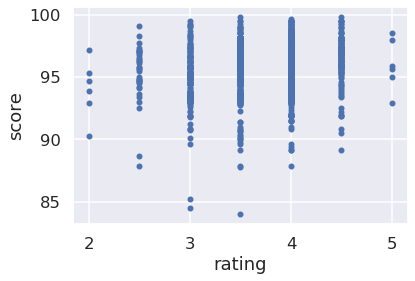

In [12]:
scatter = df.plot.scatter(x='rating', y='score')

Finally, we compare the health score and the rating and we see that there may be a slight correlation but overall it is hard to measure anything significant. 

I first wanted to show visually the correlation between the health scores and the violations so that later I could point to the overall score later on in my approach. Then I used the violations in correspondence to the yelp review score to see if there was significant differnce through the t test. It is important to note that I specifically dropped any row data that had less than 25 yelp reviews. This is mostly because I wanted to get rid of the outliers that may potentially come about from low review counts. 

I used this approach for my dataset mainly because I thought it would best visualize the results. The line plot was my original approach but the graph looked extremely messy and hard to read. The scatter plot seemed to be better as it helps show the density of some scores. Most of data I recieved was within a relatively small range. 

Overall the results showed no correlation along with no significant difference. Personally, however, I find it difficult to completely agree with these results due to limitations in my approach as well as the data. 

# Ethics & Privacy

In terms of ethics and privacy, there are a few key points to make out. One is that we were provided the data I used in this project and did use it for the intended purpose. In regards to privacy, I cleaned out most of the non pertinent information and the rest of the information that was left over was public information in regards to companies. The phones numbers and all ethical and privacy issues pertaining to the information was all cleaned out. There are definitely lots of potential biases within our dataset. For example, in terms of customers, there is only a small subset of people who actually give reviews to businesses. Furthermore, there are definitely biases in regards to the business as customers normally do not get to see the whole picture in terms of the back operation of the restaurant and so the review can be biased towards the appearance of the establishment as well as the quality of the food. 

As I mentioned before, the main method I will use to handle the issues talked about will be through parsing and cleaning the data given to me. I will anonymize the data by clearing out the data columns I do not need. For example, I parsed through the phone numbers that were provided with each establishment. The rest of the information that is used within the dataframe is all public information that anyone could find. In terms of biases, I did not and cannot access the individual reviewers of the establishment. 

# Conclusion & Discussion

The data visualized helped me understand that overall, it was hard to find a significant difference or relationship between violations and yelp rating. Overall, my question of if a yelp review score had any correlation with health inspection violations was answered. The data provided was very useful in that it provided very detailed information about the inspection process as well as the review data. The results show that even though, visually, there may be a slight correlation, statistically, it shows no correlation. However my conclusion is not exactly the same, I believe that due to certain limitations, one cannot concretely say that there is no correlation. 

One strong limiation is the amount of reviews that yelp has provided. When parsing through the data, it is hard to say how many reviews an establishment should have before it shows significance. Another limitation would be the process of the health inspecitons themselves. Health inspections do random visits to establishments and record the amount of violations while letting the establishment know. Then the inspector comes back after two weeks to two months for another inspection but they generally focus on the previous violations. This practice skews the inspection numbers as they can record the inspection down with lower violations than before if the establishment has already made the adjustments. Furthermore, as I had averaged the violations together among the inspections per establishment, it further skews the data. 

This will probably have a small impact on society. Overall my findings were not very strong so it is hard to take away anything for this project. However, it may help others try to find different approaches or be inspired so there is still some impact